In [1]:
import numpy as np
import random
try:
    import tabulate
except ImportError:
    pass
import matplotlib.pyplot as plt
import csv

random.seed(1234567)
plt.style.use('bmh')

In [2]:
def read_iris_data_set(testsetfrac=.33333, dump=False):
    """
    read, reformat, shuffle and split data between trainning and test sets
    
    inputs:
        - testsetfrac: fraction of data to be used for the test set
        - dump: dump data if True
    
    return: trainning set, test set
    """
    
    # read data
    dataset = list(csv.reader(open('iris_dataset.csv','r')))
    
    # dump data
    if dump:
        varnames = ['sepal length [cm]', 'sepal width [cm]', 'petal length [cm]', 'petal width [cm]', 'class']
        print ('nombre de données', len(dataset),'\n')
        print (tabulate.tabulate(dataset, varnames))
    
    # reformat data
    convert = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2 }
    for row in dataset:
        for line in range(len(row)-1):
            row[line] = float(row[line])
        row[len(row)-1] = convert[row[len(row)-1]]
        
    # shuffle and split data
    random.shuffle(dataset)
    ntest = int(round(len(dataset)*testsetfrac))
    
    return np.array(dataset[ntest:]), np.array(dataset[:ntest])

train_set, test_set = read_iris_data_set()

In [3]:
train_set[..., -1]

array([1., 1., 0., 2., 1., 0., 2., 1., 2., 1., 2., 0., 2., 1., 2., 1., 1.,
       0., 0., 0., 2., 2., 1., 1., 1., 2., 1., 0., 0., 0., 2., 0., 1., 0.,
       2., 2., 0., 0., 1., 1., 0., 0., 1., 2., 1., 2., 1., 2., 1., 2., 1.,
       2., 0., 1., 1., 0., 0., 2., 1., 2., 2., 2., 1., 0., 2., 2., 2., 0.,
       0., 0., 2., 0., 1., 1., 2., 1., 1., 0., 2., 1., 2., 0., 2., 2., 1.,
       1., 2., 0., 1., 0., 2., 0., 2., 0., 0., 1., 1., 0., 1., 2.])

In [4]:
np.unique(train_set[..., -1], return_counts=True)

(array([0., 1., 2.]), array([31, 35, 34]))

## Arbre de décision

La classe ```DecisionTree``` permet de construire un arbre de décision à partir de données d'entrainements. On utilise une structure algorithmique d'arbre binaire (à 2 branches) qui correspond à la structure de l'arbre de décision. 

Soit l'objet correspond à une extrémité de l'arbre (une feuille) et n'a pas de sous-branche : dans ce ca ```self.id``` correspond à la catégorie majoritaire pour cette feuille. Soit l'objet a 2 branches, ```self.left``` et ```self.right``` qui sont eux aussi des instances de la classe ```DecisionTree```. 

Le critère d'arrêt d'une branche est définit dans la méthode ```stop``` : profondeur max atteinte, ou taille minimale de donnée atteinte ou données appartenant à une seule catégorie. 

La méthode ```define_cut``` permet de trouver la meilleure coupure (donnant la plus petite valeur de l'indice Gini)

La méthode ```__call__``` permet de trouver la catégorie correspondant à la donnée d'entrée. Cette méthode parcourt l'arbre de manière itérative jusqu'à la feuille correspondant à la donnée. 

In [5]:
class DecisionTree:
    """
    DecisionTree class
 
 
    """

    maxdepth = 10
    minsize = 1
    
    def __init__(self, data, depth=0):
        self.depth = depth+1
        if self.stop(data):
            categories, counts = np.unique(data[...,-1], return_counts=True)
            self.id = categories[np.argmax(counts)]
        else:
            self.index, self.val, (left, right) = self.find_cut(data)
            self.left, self.right = DecisionTree(left, depth+1), DecisionTree(right, depth+1)
            self.id = -1
    
    def stop(self, data):
        """ 
        stop criterion 
        return true to stop tree splitting
        """
        if self.depth == self.maxdepth or len(data) <= self.minsize:
            return True
        if len(np.unique(data[..., -1])) == 1: 
            return True
        return False
        
    def gini_index(self, index, value, data):
        """
        return the sum of the weighted Gini index 
        """
        groups = self.split(index, value, data)
        # counts =  [ [count_left_class1, count_left_class2, ...],
        #             [count_right_class1, count_right_class2, ...] ]
        counts = [np.unique(group[..., -1], return_counts=True)[1] for group in groups]
        n_instances = float(np.sum(np.concatenate(counts)))
        return np.sum((1-np.sum((cc/np.sum(cc))**2)) * (np.sum(cc) / n_instances) for cc in counts)
      
    def split(self, index, value, data):
        """
        split dataset in two parts
        
        return two sublists: 
            left : data for which data[index]<=value
            right : data for which data[index]>value
        """
        return data[data[...,index]<=value], data[data[...,index]>value]
        
    def find_cut(self, data):
        """
        find best cut (index and value)
        
        return: index, value and the two subgroups for which the gini factor is minimum
        """
        scores = [(index, row[index], self.gini_index(index, row[index], data)) 
                        for index in range(len(data[0])-1) for row in data]
        b_index, b_value, b_score =  min(scores, key=lambda x:x[2])
        return b_index, b_value, self.split(b_index, b_value, data)
        
    def __call__(self, data):
        """
        return the category corresponding to data.
        """
        if self.id >= 0:
            return self.id
        return self.right.__call__(data) if data[self.index] > self.val else self.left(data)
            
    def dump(self, valnames=None):
        tab = '    |' * (self.depth-1)
        if self.id>=0:
            print (tab,'>>> %d'% self.id )
        else:
            name = valnames[self.index] if valnames else'val[%d]'%self.index
            print (tab, ' %s <= %g: '%(name, self.val))
            self.left.dump(valnames)
            print (tab, ' %s >  %g: '%(name, self.val))
            self.right.dump(valnames)

In [6]:
tree = DecisionTree(train_set)

/Users/derome/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [11]:
tree.right.left.left.id

1.0

In [12]:
tree.dump()

  val[2] <= 1.9: 
    | >>> 0
  val[2] >  1.9: 
    |  val[3] <= 1.6: 
    |    |  val[2] <= 4.9: 
    |    |    | >>> 1
    |    |  val[2] >  4.9: 
    |    |    |  val[0] <= 6: 
    |    |    |    |  val[1] <= 2.2: 
    |    |    |    |    | >>> 2
    |    |    |    |  val[1] >  2.2: 
    |    |    |    |    | >>> 1
    |    |    |  val[0] >  6: 
    |    |    |    | >>> 2
    |  val[3] >  1.6: 
    |    | >>> 2


In [13]:
for i in range(10):
    print (tree(test_set[i]),test_set[i][-1])

1.0 1.0
2.0 1.0
0.0 0.0
2.0 2.0
2.0 2.0
0.0 0.0
0.0 0.0
1.0 1.0
2.0 2.0
1.0 1.0


In [14]:
# Liste des réponse de l'arbre 
Y = np.array([tree(data) for data in test_set])
# proportion des bonnes réponses
X = np.array(test_set)
float(list(Y-X[:,-1]).count(0))/len(Y-X[:,-1])

0.96

In [15]:
varnames = ['sepal length [cm]', 'sepal width [cm]', 'petal length [cm]', 'petal width [cm]']
tree.dump(varnames)

  petal length [cm] <= 1.9: 
    | >>> 0
  petal length [cm] >  1.9: 
    |  petal width [cm] <= 1.6: 
    |    |  petal length [cm] <= 4.9: 
    |    |    | >>> 1
    |    |  petal length [cm] >  4.9: 
    |    |    |  sepal length [cm] <= 6: 
    |    |    |    |  sepal width [cm] <= 2.2: 
    |    |    |    |    | >>> 2
    |    |    |    |  sepal width [cm] >  2.2: 
    |    |    |    |    | >>> 1
    |    |    |  sepal length [cm] >  6: 
    |    |    |    | >>> 2
    |  petal width [cm] >  1.6: 
    |    | >>> 2


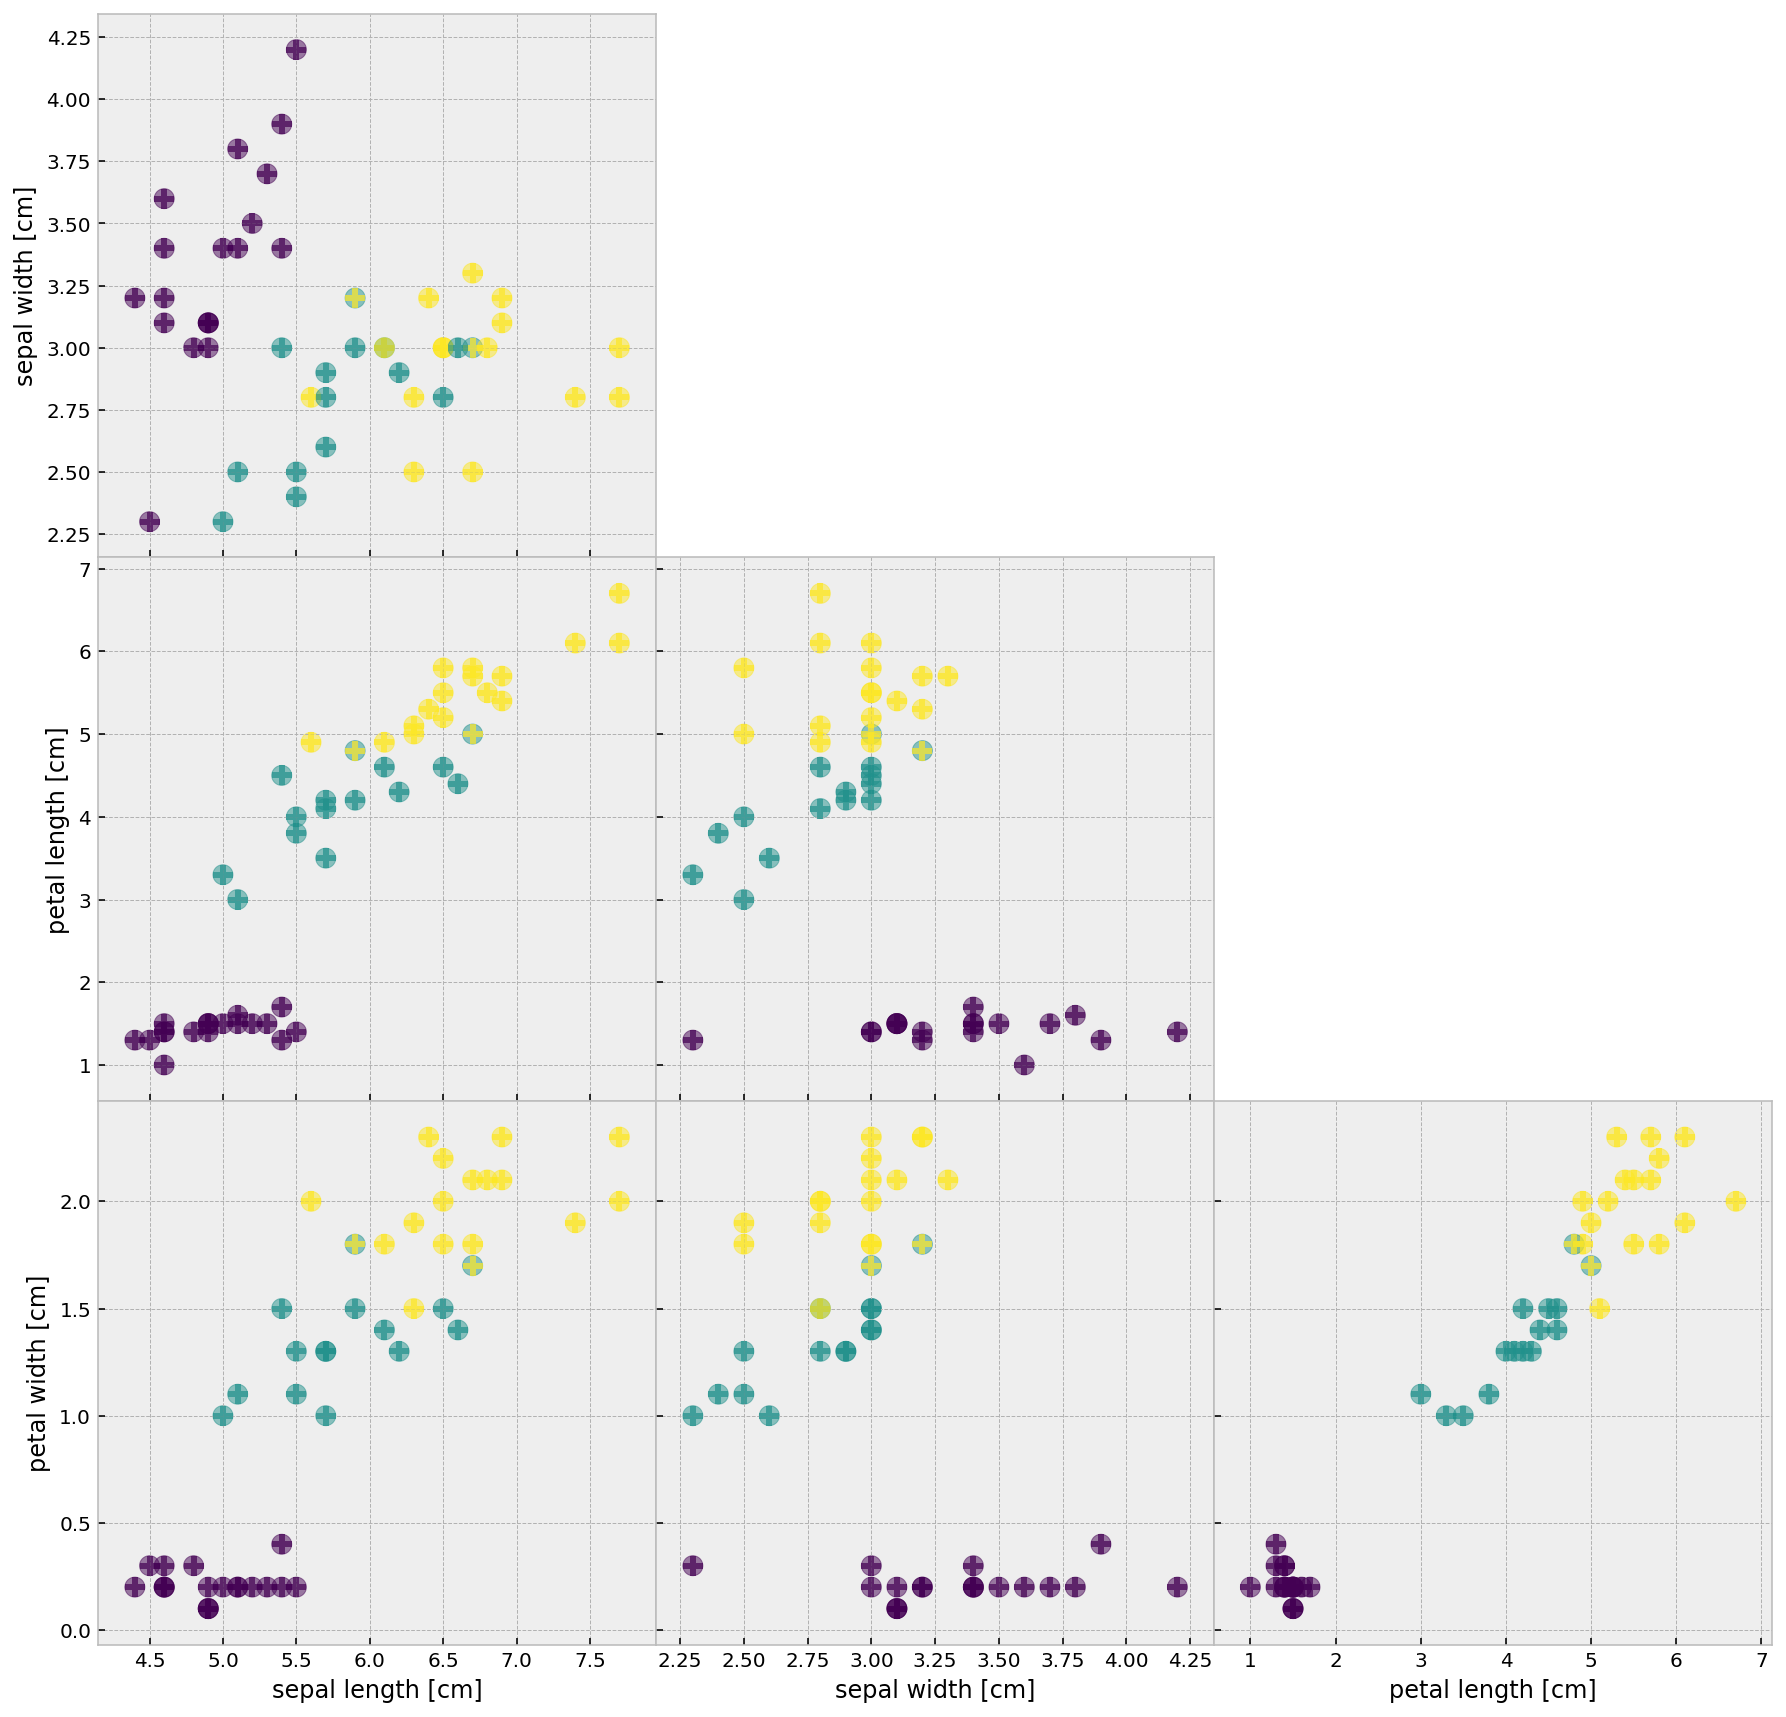

In [16]:
dim = len(test_set[0])-1
varnames = ['sepal length [cm]', 'sepal width [cm]', 'petal length [cm]', 'petal width [cm]']
fig, ax = plt.subplots(dim-1,dim-1,figsize=(15,15),sharex='col',sharey='row')
for i in range(dim-1):
    for j in range(dim-1):
        if j>i: 
            ax[i][j].set_visible(False)
        else:
            ax[i][j].scatter(X[:, j], X[:, i+1], c=X[:,-1],s= 100, alpha=.5)
            ax[i][j].scatter(X[:, j], X[:, i+1], c=Y, s= 100, zorder=10, marker='+', lw=3, alpha=.7)
            if i==2: ax[i][j].set_xlabel(varnames[j])
            if j==0: ax[i][j].set_ylabel(varnames[i+1])
plt.subplots_adjust(wspace=0., hspace=0.)
plt.show()

## Boosting
L'algorithme de l'arbre de décision n'est pas utilisé seul comme présenté dans cet exemple. Il est en général utilisé avec la méthode du 'boosting'. On parle d'arbre de décisions boostés (BDT: Boosted decision tree). 

L’idée du Boosting est d'itéret pour focaliser l’apprentissage sur les exemples difficiles, c’est à dire les données d'entrainement mal classées. Cette modification de l’importance donnée aux données est réalisée en modifiant les poids des données au cours des différentes itérations. Les données mal classées voient leur poids augmenté, de sorte que l'arbre suivant se concentre en priorité sur ces exemples difficiles. Les différents arbres sont alors combinées par un vote pondéré. La figure suivante (tirée de la thèse de David Gacquer) illustre la méthode du boosting.

<figure>
<img src="boosting.png" alt="setosa" style="width: 800px;"/>
</figure>